In this notebook we explore image quantization by applying the $k$-means algorithm to a sample flower image. We will explore how different values of $k$ affects the quality of the resulting image and the computational complexity of the algorithm.

# Implemented Modules

All modules within this section have been personally implemented by the author using `NumPy` and `Matplotlib` libraries. You can find the source code on [GitHub](https://github.com/dylannalex/ML-Lab/tree/main/image_quantization/src).

**src.image**

* `Image`: Represents an image with attributes such as RGB matrix, RGB vector, shape, and title.

* `load_image(image_path: str) -> Image`: Loads an image from the given file path, converts it to RGB format, and returns an Image object.

* `rgb_vector_to_image(rgb_vector: np.ndarray, image_shape: tuple) -> Image`: Converts an RGB vector to an Image object with the specified shape.

* `display_images(*images: Image, figsize=(10, 5))`: Displays images using matplotlib.

* `plot_rgb_vector(rgb_vector: np.ndarray, figsize=(10, 5), title=None, alpha=0.6, s=4)`: Plots a 3D scatter plot of RGB vectors.

In [27]:
from src import image

**src.model**

* `KMeans`: Implements the $k$-means clustering algorithm with parameters for the number of clusters (`n_clusters`), tolerance (`tol`), maximum iterations (`max_iter`), and random state (`random_state`).

* `KMeans.fit(X: np.ndarray) -> KMeans`: Fits the KMeans model to the input data X using the specified parameters.

* `KMeans.labels_`: An array of shape `(n_samples,)` where each element represents the cluster index assigned to the corresponding sample.

* `KMeans.cluster_centers_`: An array of shape `(n_clusters, n_features)` representing the final cluster centers after fitting the model. Each row corresponds to the centroid of a cluster in the feature space.

* `plot_k_metrics(k_values: list[int], clusters_cost_list: list[float], execution_time_list: list[float], figsize: tuple = (10, 4))`: Plots the clusters cost and execution time of $k$-means for different values of $k$.


In [28]:
from src import model

## Try it yourself

To try out these modules, simply follow these steps:

1. Download the source code [here](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/dylannalex/ML-Lab/tree/main/image_quantization)

2. Go to the */image_quantization* folder

3. Install required packages: `pip install -r requirements.txt`

4. Create a notebook or Python file in the */image_quantization* folder

5. You're all set! You can import the modules as `from src import image, model`

# Image Quantization

One of the applications of $k$-means is image quantization (specifically, color quantization), which consists in reducing the number of distinct colors used in an image, usually with the intention that the new image should be as visually similar as possible to the original image.

Let's explore this concept by applying the $k$-means algorithm to a sample image ([daisy image, by Bessi](https://pixabay.com/es/photos/margarita-flor-blanco-bloom-729510/)).

## Loading the Image

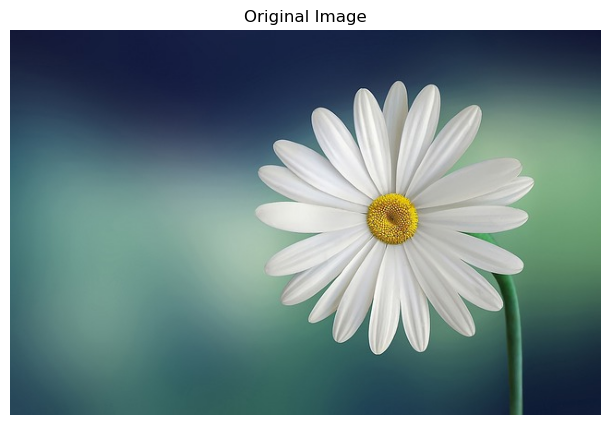

In [29]:
import numpy as np

img = image.load_image("img/flower.jpg")
img.title = "Original Image"
image.display_images(img)

The image is loaded as matrix $M \in \mathbb{R}^{n \times m \times 3}$ where $M_{ij}$ is the pixel from the row $i$ and column $j$:

In [30]:
img.rgb_matrix.shape

(417, 640, 3)

To fit the $k$-means algorithm, the image matrix $M$ has to be converted into a feature matrix $X \in \mathbb{R}^{n \cdot m \times 3}$ where $X_i$ represents the feature vector $x^{(i)}$:

In [31]:
img.rgb_vector.shape

(266880, 3)

We can visualize the feature vectors in the 3-dimensional space:

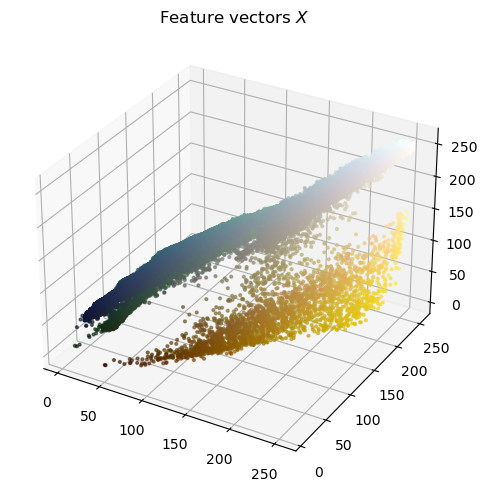

In [32]:
image.plot_rgb_vector(img.rgb_vector, title="Feature vectors $X$")

## Applying $k$-means

We will experiment with three different values for $k$: 8, 16 and 32. This means that we will aim to represent the entire spectrum of colors in the image using either 8, 16 or 32 distinct colors. The $k$-means algorithm will group similar colors together and assign them to the same cluster, effectively reducing the variety of colors present in the image.

### $8$-means

First we train the model with $8$ clusters.

In [33]:
k8_means = model.KMeans(n_clusters=8, random_state=44)
%time k8_means.fit(img.rgb_vector)

CPU times: total: 10.9 s
Wall time: 11.3 s


We can inspect executed iterations, and the labels and centroids found.

In [34]:
k8_means.iterations

72

In [35]:
k8_means.labels_

array([6, 6, 6, ..., 6, 6, 6], dtype=int64)

In [36]:
k8_means.cluster_centers_

array([[ 42.39915168,  67.65893264,  84.11651684],
       [ 87.46747399, 127.68052914, 119.33007048],
       [191.76564391, 194.46557984, 189.38218125],
       [114.46671081, 156.33419082, 139.91508329],
       [ 60.50504249,  99.93731908, 100.45057895],
       [152.42347775, 174.89832302, 153.38496535],
       [ 24.28310161,  36.94729513,  65.34303884],
       [223.21554659, 224.39480287, 222.18355735]])

As we can observe, each centroid is a 3-dimensional floating-point array. Consequently, we need to cast this array to an integer array.

In [37]:
k8_colors = np.uint8(k8_means.cluster_centers_)
k8_colors

array([[ 42,  67,  84],
       [ 87, 127, 119],
       [191, 194, 189],
       [114, 156, 139],
       [ 60,  99, 100],
       [152, 174, 153],
       [ 24,  36,  65],
       [223, 224, 222]], dtype=uint8)

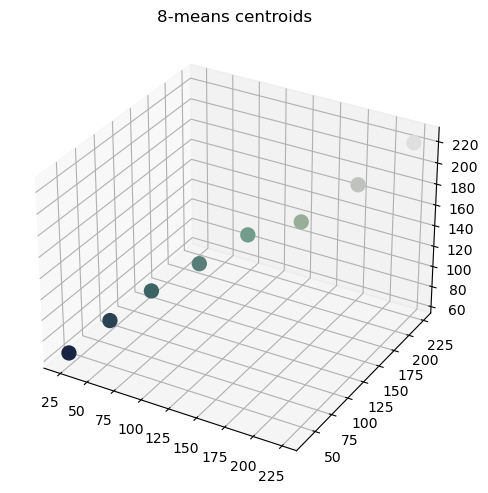

In [38]:
image.plot_rgb_vector(k8_colors, alpha=1, s=100, title="8-means centroids")

To obtain the quantized image, we simply replace each pixel's feature vector with the corresponding centroid of the cluster to which it belongs:

In [39]:
k8_rgb_vector = k8_colors[k8_means.labels_]

Finally, we can display the quantized image:

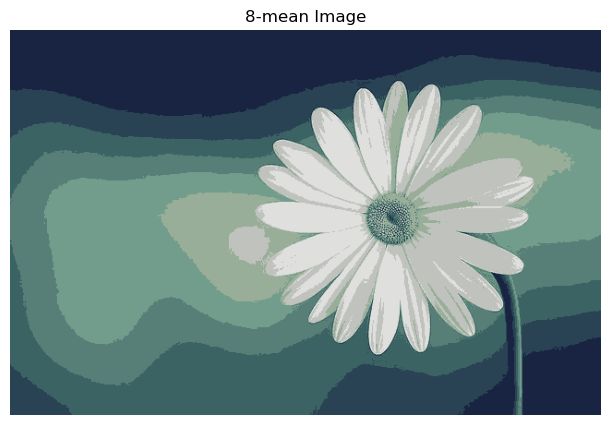

In [40]:
k8_image = image.rgb_vector_to_image(k8_rgb_vector, img.shape)
k8_image.title = "8-mean Image"
image.display_images(k8_image)

To accelerate this process we create a function `quantize_image()`, that given the image to quantize and the value of $k$, trains the $k$-means model, shows the training status (time and iterations executed), and displays the centroids and the resulting quantized image. It returns the quantized image.  

In [41]:
def quantize_image(img: image.Image, k: int, random_state: int):
    kmeans = model.KMeans(n_clusters=k, random_state=random_state)

    # Training
    print("[Training]")
    %time kmeans.fit(img.rgb_vector)
    print(f"Iterations: {kmeans.iterations}")

    # Results
    print("\n[Results]")
    centroids = np.uint8(kmeans.cluster_centers_)
    print(f"{k}-means centroids:")
    image.plot_rgb_vector(centroids, alpha=1, s=100, title=f"{k}-means centroids")

    quantized_img = image.rgb_vector_to_image(centroids[kmeans.labels_], img.shape)
    quantized_img.title = f"{k}-mean image"

    print("Quantized image:")
    image.display_images(quantized_img)

    return quantized_img

### $16$-means

We can now train the $16$-means algorithm with the function we created:

[Training]


CPU times: total: 25.8 s
Wall time: 26.2 s
Iterations: 100

[Results]
16-means centroids:


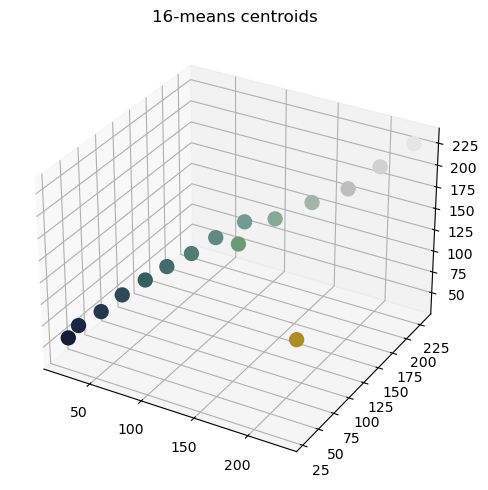

Quantized image:


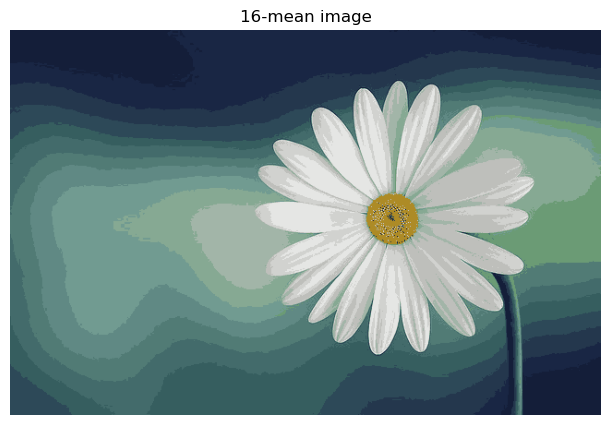

In [42]:
k16_image = quantize_image(img, k=16, random_state=44)

The quantized image produced by the $16$-means algorithm shows an improvement in similarity to the original. Nevertheless, the processing time is significantly longer.

### $32$-means

Finally, we quantize the image with $k = 32$. From our previous observations, we expect the quantized image to be more similar to the original, and an increase in the execution time.

[Training]


CPU times: total: 36.3 s
Wall time: 36.5 s
Iterations: 76

[Results]
32-means centroids:


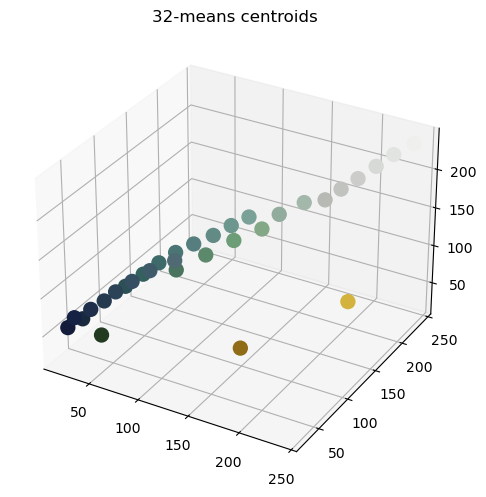

Quantized image:


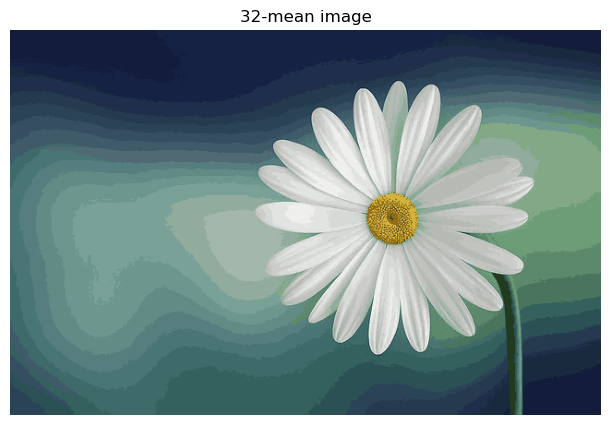

In [43]:
k32_image = quantize_image(img, k=32, random_state=44)

## Comparison

By comparing the results obtained with $k=8$, $k=16$ and $k=32$, we can observe how the choice of the number of centers influences the visual appearance of the image. A smaller value of $k$ may result in a more pronounced reduction in color variety, while a larger $k$ might preserve more intricate details in the color distribution. 

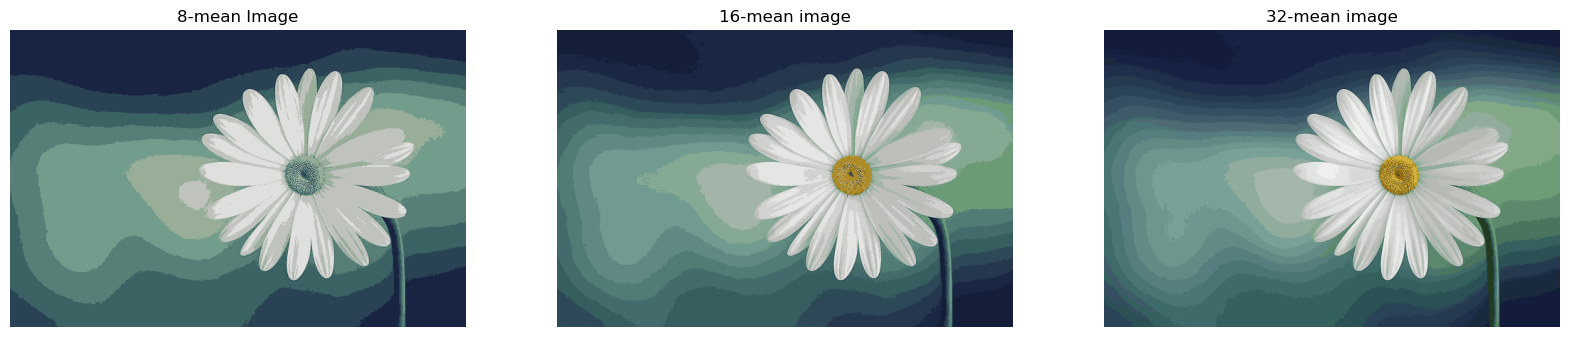

In [44]:
image.display_images(k8_image, k16_image, k32_image, figsize=(20, 15))

It's worth noting that, in addition to the visual impact, the computational complexity of the algorithm increases with a larger value of $k$. Therefore, the choice of $k$ involves a trade-off between computational efficiency and the level of detail preserved in the color representation.

# Quality measure and execution time

We can quantify the image quality with a clusters cost function, which measures the squared Euclidean distance between each feature vector $x^{(i)}$ and its representative (i.e., cluster centroid) $z_j$ from the cluster $C_j$.

$$
\text{cost}(z_1, \dots, z_k) = \sum_{j=1}^k \sum_{i \in C_j} ||x^{(i)} - z_j||^2
$$

In [45]:
def clusters_cost(X, centroids, labels):
    cost = 0
    for j in range(len(centroids)):
        cluster = X[np.where(labels == j)]
        distance = np.linalg.norm(cluster - centroids[j])**2
        cost += np.sum(distance)
    return cost

If we analyze our dataset $X$ representing the pixels of our image, we can count the number of distinct colors the image has:

In [46]:
len(np.unique(img.rgb_vector, axis=0))

25786

A quantization with $0$ clusters cost would require a value $k=25786$, as we would need a centroid for each unique color of the image. This is not feasible due to the significant computational load, and the resulting quantized image would not be of much use. Consequently, we have to limit the range of $k$ to analyze how the cluster cost and time execution evolve as $k$ increases.

The `model.plot_k_metrics()` function plots the change in clusters cost and execution time for different values of $k$. To use this function, we first need to train the model for the list of values of $k$ and record the clusters cost and execution time at each step. To accomplish this and handle the intensive computation more efficiently, we create a `record_k_metrics()` function. We utilize the highly optimized `sklearn.cluster.KMeans` class to significantly improve the execution time. Please note that our implementation, `model.KMeans`, has an identical interface to `sklearn.cluster.KMeans`, except for the parameter `n_init`, which is not implemented in `model.KMeans`.


In [47]:
from sklearn.cluster import KMeans
from time import time

def record_k_metrics(
    img: image.Image, 
    k_values: list[int], 
    random_state: int,
    ):
    # Train the model for each k
    execution_time_list = []
    clusters_cost_list = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=5)
        # Execution time
        start_time = time()
        kmeans.fit(img.rgb_vector)
        end_time = time()
        execution_time_list.append(end_time - start_time)
        # Clusters cost
        centroids = np.uint8(kmeans.cluster_centers_)
        cost = clusters_cost(img.rgb_vector, centroids, kmeans.labels_)
        clusters_cost_list.append(cost)

    return clusters_cost_list, execution_time_list

We can visualize the clusters cost and execution time for $k = 2, 4, 6, \dots, 64$:

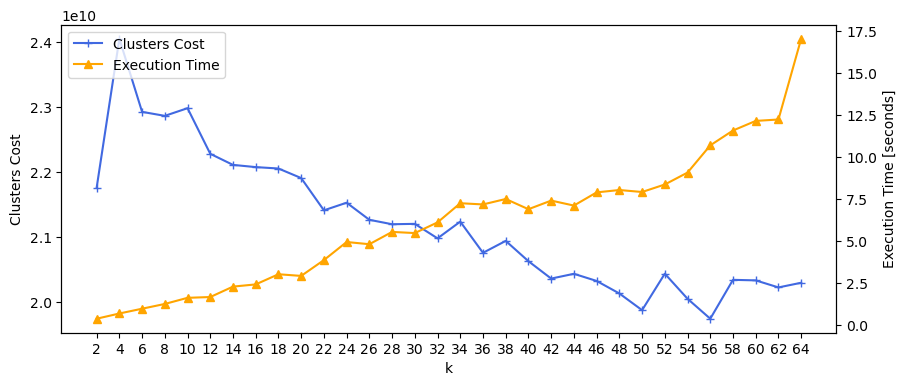

In [48]:
k_values = list(range(2, 65, 2))
clusters_cost_list, execution_time_list = record_k_metrics(img, k_values, random_state=44)
model.plot_k_metrics(k_values, clusters_cost_list, execution_time_list)

As $k$-means is a stochastic algorithm, the relationship between $k$ and the metrics introduces some noise, resulting in occasional fluctuations in the function. Nevertheless, a discernible decreasing trend in clusters cost and an increasing trend in execution time become evident as $k$ increases.

# Conclusion

In this exploration of image quantization using the $k$-means algorithm, we delved into the intricacies of color reduction in a sample flower image. By varying the number of clusters ($k$) and applying $k$-means clustering, we observed the impact on image quality and computational complexity.

Experimenting with $k$-means using $8$, $16$, and $32$ clusters provided distinct insights into the trade-offs between color variety and computational efficiency. We visualized the resulting images, analyzed cluster centroids, and compared the clusters' cost function across different k values.

Further, we explored the influence of $k$ on execution time and clusters cost. The `plot_k_metrics()` function facilitated a comprehensive view of these metrics, shedding light on the intricate relationship between the number of clusters and computational performance.

This project, though a humble beginning, marks a significant step in understanding the nuances of image quantization. Your feedback and thoughts are invaluable as we continue to refine and expand our exploration of machine learning concepts.

Thank you for joining me on this journey, and I look forward to hearing your insights and suggestions.
